# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [99]:
# import libraries
import re
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sqlalchemy import create_engine

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download(['punkt', 'wordnet'])

[nltk_data] Downloading package punkt to /home/ambreen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ambreen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.1.


In [3]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql('select * from Messages', engine)
df.drop(columns = ['id', 'original'], inplace = True)
X = df[['message', 'genre']]
Y = df.loc[:, ~df.columns.isin(X.columns)]
display(X.columns)
display(Y.columns)

Index(['message', 'genre'], dtype='object')

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

### Clean data for modeling

`related` has 3 classes: 0, 1, and 2. Since the number of records with the class 2 in this label is very small, I'm counting it as class type 1

In [4]:
Y['related'].value_counts()/Y.shape[0]

1    0.759307
0    0.233522
2    0.007171
Name: related, dtype: float64

In [5]:
Y_mod = Y

In [6]:
Y_mod.replace(to_replace = 2, value = 1, inplace = True)

/home/ambreen/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [7]:
Y_mod.describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,0.766478,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,0.423079,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Labels with only one class i.e. 0 is removed so I can use different scoring methods without running into errors

In [8]:
Y_mod.sum() == 0

related                   False
request                   False
offer                     False
aid_related               False
medical_help              False
medical_products          False
search_and_rescue         False
security                  False
military                  False
child_alone                True
water                     False
food                      False
shelter                   False
clothing                  False
money                     False
missing_people            False
refugees                  False
death                     False
other_aid                 False
infrastructure_related    False
transport                 False
buildings                 False
electricity               False
tools                     False
hospitals                 False
shops                     False
aid_centers               False
other_infrastructure      False
weather_related           False
floods                    False
storm                     False
fire    

In [9]:
Y_mod = Y_mod.drop(columns = ['child_alone'])

### 2. Write a tokenization function to process your text data

In [10]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, 'urlplaceholder', text)    
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(x).lower().strip() for x in tokens]
    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [11]:
pipeline1 = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultiOutputClassifier(AdaBoostClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
X_msg = X['message']
X_train, X_test, y_train, y_test = train_test_split(X_msg, Y_mod)

In [13]:
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f52d8637680>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 MultiOutputClassifier(estimator=AdaBoostClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [14]:
y_pred1 = pipeline1.predict(X_test)

In [15]:
cols = Y_mod.columns.values
sum_macro_avg = 0

for i in range(0, len(cols)):
    print(f'{cols[i]}')
    print('-'*55)
    c_pred = y_pred1[:,i]
    c_true = y_test[cols[i]]
    print(classification_report(c_true, c_pred))

related
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.34      0.45      1568
           1       0.82      0.95      0.88      4986

    accuracy                           0.80      6554
   macro avg       0.74      0.64      0.66      6554
weighted avg       0.78      0.80      0.77      6554

request
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      5411
           1       0.76      0.55      0.64      1143

    accuracy                           0.89      6554
   macro avg       0.83      0.76      0.79      6554
weighted avg       0.88      0.89      0.88      6554

offer
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6529
           1       0.00      0.00      0.00    

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4725
           1       0.85      0.67      0.75      1829

    accuracy                           0.88      6554
   macro avg       0.87      0.81      0.83      6554
weighted avg       0.87      0.88      0.87      6554

floods
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6015
           1       0.88      0.56      0.69       539

    accuracy                           0.96      6554
   macro avg       0.92      0.78      0.83      6554
weighted avg       0.96      0.96      0.95      6554

storm
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5907
           1       0.76      0.53      0.62       647

    accuracy                           0.94      6554
   

In [109]:
def display_scores(y_true, predicted):
    display(f1_score(y_test, predicted, average = 'weighted'))
    display(roc_auc_score(y_true, predicted, multi_class = 'ovo', average = 'weighted'))

In [16]:
f1_score(y_test.values, y_pred1, average = 'weighted')

0.6342734489694501

In [17]:
roc_auc_score(y_test, y_pred1, multi_class = 'ovo', average = 'weighted')

0.6993409287861484

In [18]:
print(classification_report(y_test.values, y_pred1))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4986
           1       0.76      0.55      0.64      1143
           2       0.00      0.00      0.00        25
           3       0.76      0.60      0.67      2696
           4       0.58      0.26      0.36       542
           5       0.63      0.32      0.42       330
           6       0.60      0.22      0.32       176
           7       0.27      0.03      0.06       117
           8       0.62      0.33      0.43       206
           9       0.72      0.66      0.69       399
          10       0.79      0.72      0.76       730
          11       0.77      0.56      0.65       579
          12       0.61      0.36      0.45        97
          13       0.52      0.24      0.33       148
          14       0.69      0.21      0.32        87
          15       0.65      0.25      0.36       215
          16       0.73      0.43      0.54       298
          17       0.53    

/home/ambreen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ambreen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6. Improve your model
Use grid search to find better parameters. 

In [20]:
from sklearn.metrics import precision_recall_fscore_support

In [59]:
vect = CountVectorizer(tokenizer = tokenize)
tfidf = TfidfTransformer()
y_true = y_test.values
perf = []
y_preds_all = dict()

candidates = [
    ['AdaBoost', MultiOutputClassifier(AdaBoostClassifier())],
    ['RandomForest', RandomForestClassifier()],
    ['ExtraTreesClassifier', ExtraTreesClassifier()],
    ['DecisionTreeClassifier', DecisionTreeClassifier()]
]

for i in range(len(candidates)):
    p = Pipeline([
        ('vect', vect),
        ('tfidf', tfidf),
        ('classifier', candidates[i][1])
    ])
    
    candidates[i][1] = p.fit(X_train, y_train)
    pred = p.predict(X_test)
    y_preds_all[candidates[i][0]] = pred
    sf1 = f1_score(y_true, pred, averageAlone = 'weighted', labels = np.unique(pred))
    sauc = roc_auc_score(y_true, pred, multi_class = 'ovo', average = 'weighted')
    perf.append([sauc, sf1])

In [60]:
score_names = ['AUC', 'F-1']

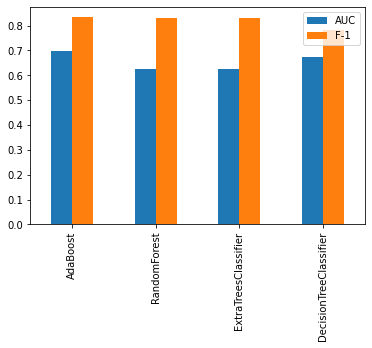

In [61]:
import matplotlib.pyplot as plt

score_df = pd.DataFrame(perf, columns = score_names, index = list(map(lambda x:  x[0], candidates)))
score_df.plot(kind = 'bar')

Looks like adaBoost has better F-1 and AUC combination so using it as the estimator for parameter searching.

In [62]:
selected_pipeline = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('classifier', MultiOutputClassifier(AdaBoostClassifier()))
])

In [63]:
selected_pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x7f52d8637680>)),
  ('tfidf', TfidfTransformer()),
  ('classifier', MultiOutputClassifier(estimator=AdaBoostClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x7f52d8637680>),
 'tfidf': TfidfTransformer(),
 'classifier': MultiOutputClassifier(estimator=AdaBoostClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 '

In [65]:
parameters = {
    'classifier__estimator__learning_rate': [0.2, 0.4, 0.6, 0.8, 1],
    'tfidf__use_idf': [True, False],
    'classifier__estimator__algorithm':['SAMME', 'SAMME.R'],
    'classifier__estimator__n_estimators': [5, 10, 15, 20, 30, 40, 50],
    }

cv = GridSearchCV(selected_pipeline, param_grid = parameters, verbose = 2, n_jobs = -1)

In [66]:
%%time

cv.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 75.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 137.5min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 153.0min finished


CPU times: user 1min 57s, sys: 1.69 s, total: 1min 59s
Wall time: 2h 34min 47s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7f52d8637680>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier()))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__algorithm': ['SAMME',
                                                              'SAMME.R'],
                         'classifier__estimator__learning_rate': [0.2, 0.4, 0.6,
                                                                  0.8, 1],
                         'classifier__estimator__n_estimators': [5, 10, 15, 20,
                                                                 30, 40, 50],
                         'tfidf__use_idf': [True, False]},
             verbose=2)

In [69]:
cv.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f52d8637680>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(learning_rate=0.8)))])

In [71]:
cv.best_params_

{'classifier__estimator__algorithm': 'SAMME.R',
 'classifier__estimator__learning_rate': 0.8,
 'classifier__estimator__n_estimators': 50,
 'tfidf__use_idf': True}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [72]:
y_pred2 = cv.predict(X_test)

In [74]:
display(f1_score(y_true, y_pred2, average = 'weighted', labels = np.unique(pred)))
display(roc_auc_score(y_true, y_pred2, multi_class = 'ovo', average = 'weighted'))

0.8344803894428419

0.691173423260702

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [102]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    
    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP']:
                return True
        return False
    
    def fit(self, x, y = None):
        return self
    
    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [106]:
vect = CountVectorizer(tokenizer = tokenize)
tfidf = TfidfTransformer()

pipeline_extended = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vect', vect),
            ('tfidf', tfidf)
        ])),
        ('starting_verb', StartingVerbExtractor())
    ])),
    ('classifier', MultiOutputClassifier(AdaBoostClassifier(learning_rate = 0.8)))
])

In [107]:
pipeline_extended.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7f52d8637680>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('starting_verb',
                                                 StartingVerbExtractor())])),
                ('classifier',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(learning_rate=0.8)))])

In [108]:
pred_extended = pipeline_extended.predict(X_test)

In [110]:
display_scores(y_test.values, pred_extended)

0.6234450529025545

0.691173423260702

### 9. Export your model as a pickle file

In [75]:
import pickle
s = pickle.dump(cv, open('classifier.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.